In [1]:
import pandas as pd
import json
import http.client
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def create_dataframe(yearfrom, yearto, API_key):
    """
    Create a DataFrame from the standings data for a specified range of years.

    Parameters:
        yearfrom (int): Starting year.
        yearto (int): Ending year.
        API_key (str): API key for accessing the football API.

    Returns:
        df_list (list): List of DataFrames, each containing standings data for one season.
    """
    df_list = []
    for year in range(yearfrom, yearto):
        try:
            conn = http.client.HTTPSConnection("v3.football.api-sports.io")

            headers = {
                'x-rapidapi-host': "v3.football.api-sports.io",
                'x-rapidapi-key': f"{API_key}"
                }

            conn.request("GET", f"/standings?league=39&season={year}", headers=headers)

            res = conn.getresponse()
            data = res.read()
            # Decode bytes to string
            json_string = data.decode('utf-8')

            # Parse JSON string
            json_data = json.loads(json_string)

            # Check if response contains data
            if json_data and 'response' in json_data and json_data['response']:
                standings_data = json_data['response'][0]['league']['standings'][0]

                # Convert to pandas DataFrame
                df = pd.DataFrame(standings_data)

                # Append DataFrame to the list
                df_list.append(df)
            else:
                print(f"No data available for {year}.")
        except Exception as e:
            print(f"Error occurred for {year}: {e}")

    return df_list


In [30]:
df = create_dataframe(2015,2024, API_key=None)

No data available for 2015.
No data available for 2016.
No data available for 2017.
No data available for 2018.
No data available for 2019.
No data available for 2020.
No data available for 2021.
No data available for 2022.
No data available for 2023.


In [5]:
def split_columns(lst):
    """
    Split columns containing nested JSON objects into separate DataFrames and combine them with the original DataFrame.

    Parameters:
        lst (list): A list of pandas DataFrames where each DataFrame contains columns with nested JSON objects.

    Returns:
        list: A list of pandas DataFrames with split columns combined with the original DataFrames.
    """
    # List to store DataFrames after splitting columns
    return_lst = []

    # Iterate over each DataFrame in the input list
    for df in lst:
        # Split the 'team', 'all', 'home', and 'away' columns into separate DataFrames
        df_team = pd.json_normalize(df['team'])
        df_all = pd.json_normalize(df['all'])
        df_home = pd.json_normalize(df['home'])
        df_away = pd.json_normalize(df['away'])

        # Add prefix to columns based on their original column name
        df_all = df_all.add_prefix('all_')
        df_home = df_home.add_prefix('home_')
        df_away = df_away.add_prefix('away_')

        # Combine the split columns with the original DataFrame
        df = pd.concat([df.drop(['team', 'all', 'home', 'away'], axis=1), df_team, df_all, df_home, df_away], axis=1)

        # Append the DataFrame to the return list
        return_lst.append(df)

    # Return the list of DataFrames after splitting columns
    return return_lst



In [6]:
def drop_columns(lst):
    """
    Drop specified columns from each DataFrame in a list of DataFrames.

    Parameters:
        lst (list): A list of pandas DataFrames.

    Returns:
        list: A list of pandas DataFrames with specified columns dropped.
    """
    # Initialize an empty list to store modified DataFrames
    modified_lst = []
    
    # Iterate over each DataFrame in the input list
    for df in lst:
        # Drop specified columns and create a new DataFrame without modifying the original one
        modified_df = df.drop(columns=["id", "update", "status"])
        
        # Append the modified DataFrame to the list
        modified_lst.append(modified_df)

    # Return the modified list of DataFrames
    return modified_lst


In [8]:
def column_names(df_list):
    df_list_cleaned = []
    for df in df_list:
        df=df[['rank','name', 'points', 'goalsDiff', 'group', 'form', 'description', 
         'logo', 'all_played', 'all_win', 'all_draw', 'all_lose',
         'all_goals.for', 'all_goals.against', 'home_played', 'home_win',
         'home_draw', 'home_lose', 'home_goals.for', 'home_goals.against',
         'away_played', 'away_win', 'away_draw', 'away_lose', 'away_goals.for',
         'away_goals.against']]
        df_list_cleaned.append(df)
    return df_list_cleaned

In [9]:
def make_big_df(df_list, fromyear, toyear):
    """
    Concatenate DataFrames from a list into a single DataFrame and add a 'season' column.

    Parameters:
        df_list (list): List of DataFrames to be concatenated.
        fromyear (int): Starting year.
        toyear (int): Ending year.

    Returns:
        DataFrame: The concatenated DataFrame with a 'season' column.
    """
    seasons = range(fromyear, toyear)
    for season, df in zip(seasons, df_list):
        df.loc[:, 'season'] = season  # Use .loc to avoid SettingWithCopyWarning

    # Concatenating all DataFrames into a single big DataFrame
    big_df = pd.concat(df_list, ignore_index=True)
    return big_df

    


In [10]:
def cleaner(df_list):
    """
    Clean a list of DataFrames by splitting, dropping unnecessary columns, and renaming columns.

    Parameters:
        df_list (list): List of DataFrames to be cleaned.

    Returns:
        DataFrame: The final cleaned DataFrame.
    """
    # Split columns
    df_split = split_columns(df_list)
    
    # Drop unnecessary columns
    df_dropped = drop_columns(df_split)
    
    # Rename columns
    df_final = column_names(df_dropped)
    return df_final


In [11]:
cleaned_df_list = cleaner(df)

In [12]:
pl = make_big_df(cleaned_df_list,2015,2024)

In [47]:

def plot_top_teams_position(pl, num_teams=6, figsize=(10, 6), save_path=None):
    """
    Plot the league position per season for the top N teams.

    Parameters:
        pl (DataFrame): DataFrame containing the league position data.
        num_teams (int): Number of top teams to include in the plot.
        figsize (tuple): Figure size (width, height) in inches.
        save_path (str): Path to save the plot (including filename and extension).

    Returns:
        None
    """
    # Pivot the data to have one line per team
    rank_per_season_pivot = pl.pivot_table(index='season', columns='name', values='rank', aggfunc='mean')

    # Calculate the mean rank for each team across all seasons
    mean_rank_per_team = rank_per_season_pivot.mean().sort_values()

    # Select the top N teams
    top_teams = mean_rank_per_team.head(num_teams).index

    # Filter the data to include only the top N teams
    rank_per_season_pivot_filtered = rank_per_season_pivot[top_teams]

    # Plotting
    fig, ax = plt.subplots(figsize=figsize)

    # Create the line chart
    rank_per_season_pivot_filtered.plot(kind='line', marker='o', ax=ax, markersize=6)

    # Customize the plot
    ax.set_title(f'League position per season for top {num_teams} teams', fontsize=20)
    ax.set_xlabel('Season')
    ax.set_ylabel('Rank')

    # Filter out NaN and Inf values from the data
    cleaned_values = rank_per_season_pivot_filtered.values[~np.isnan(rank_per_season_pivot_filtered.values) & ~np.isinf(rank_per_season_pivot_filtered.values)]

    # Set y-axis limits and ticks
    extra_space = 1
    ax.set_ylim(cleaned_values.min() - extra_space, cleaned_values.max())
    ax.set_yticks(np.unique(cleaned_values))
    ax.invert_yaxis()

    plt.xticks(rotation=12, fontsize=12)
    plt.yticks(fontsize=12)

    # Move legend outside of the graph
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1), title='Teams')

    plt.tight_layout()

    # Save the plot if save_path is provided
    if save_path:
        plt.savefig(save_path, dpi=300, transparent=False, bbox_inches='tight')

    plt.show()


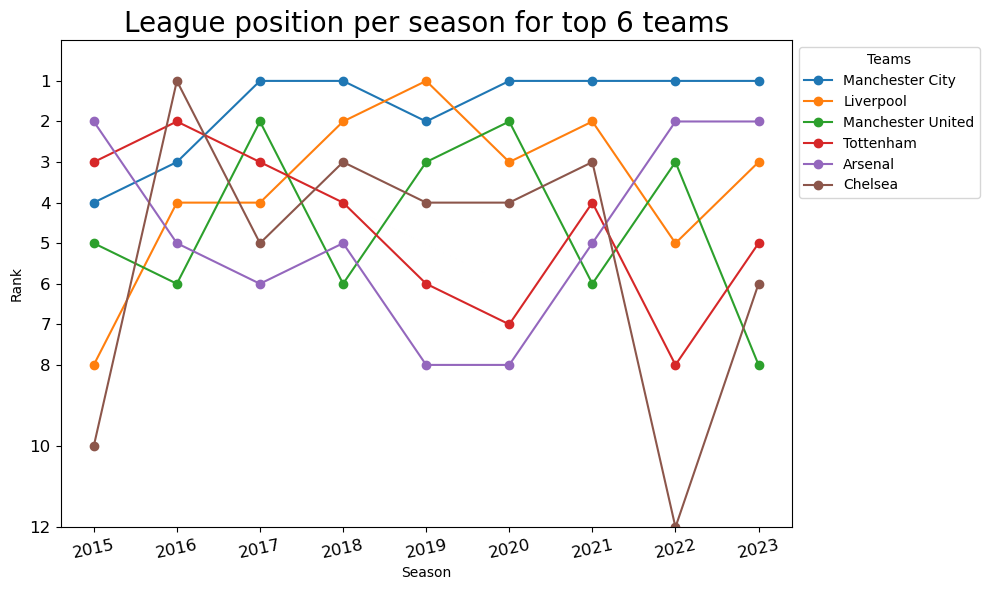

In [48]:
plot_top_teams_position(pl,save_path='top_6_positions.png')

In [33]:

def plot_top_teams_points(pl, num_teams=6, figsize=(10, 6), save_path=None):
    """
    Plot the points per season for the top N teams.

    Parameters:
        pl (DataFrame): DataFrame containing the points data.
        num_teams (int): Number of top teams to include in the plot.
        figsize (tuple): Figure size (width, height) in inches.
        save_path (str): Path to save the plot (including filename and extension).

    Returns:
        None
    """
    # Pivot the data to have one line per team
    points_per_season_pivot = pl.pivot_table(index='season', columns='name', values='points', aggfunc='mean')

    # Calculate the mean points for each team across all seasons
    mean_points_per_team = points_per_season_pivot.mean().sort_values(ascending=False)

    # Select the top N teams
    top_teams = mean_points_per_team.head(num_teams).index

    # Filter the data to include only the top N teams
    points_per_season_pivot_filtered = points_per_season_pivot[top_teams]

    # Plotting
    fig, ax = plt.subplots(figsize=figsize)

    # Create the bar chart with custom colors
    colors = ['#6CABDD', '#c8102E', '#9C824A', '#132257', '#FBE122', '#034694']
    team_colors = {team: color for team, color in zip(top_teams, colors)}
    points_per_season_pivot_filtered.plot(kind='bar', ax=ax, color=[team_colors.get(team, 'black') for team in points_per_season_pivot_filtered.columns])

    # Customize the plot
    ax.set_title(f'Points per season for top {num_teams} teams', fontsize=20)
    ax.set_xlabel('Season')
    ax.set_ylabel('Points')

    plt.xticks(rotation=12, fontsize=12)
    plt.yticks(fontsize=12)

    # Move legend outside of the graph
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1), title='Teams')

    plt.tight_layout()

    # Save the plot if save_path is provided
    if save_path:
        plt.savefig(save_path, dpi=300, transparent=False, bbox_inches='tight')

    plt.show()


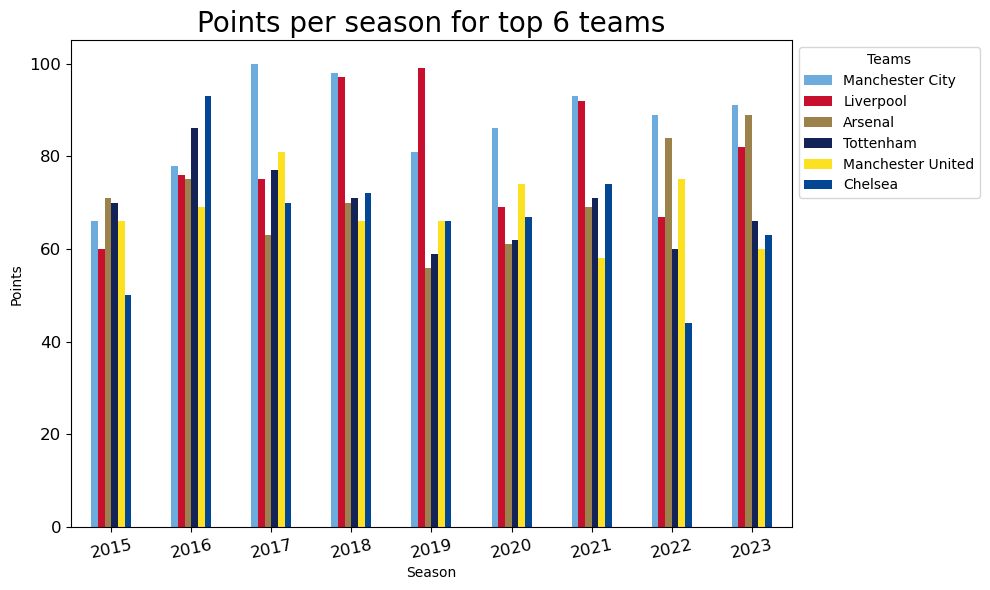

In [34]:
plot_top_teams_points(pl,save_path='top_6_points.png')

In [35]:
def plot_team_goal_difference(pl, team_name, figsize=(10, 6), save_path=None):
    """
    Plot the goal difference per season for a specific team.

    Parameters:
        pl (DataFrame): DataFrame containing the league position data.
        team_name (str): Name of the team to plot the goal difference for.
        figsize (tuple): Figure size (width, height) in inches.
        save_path (str): Path to save the plot (including filename and extension).

    Returns:
        None
    """
    # Filter the data for the specified team
    team_data = pl.loc[pl["name"] == team_name]

    # Group the data by season and calculate the mean goals for and against each season
    team_goals = team_data.groupby(["season"]).agg({'all_goals.for': 'mean', 'all_goals.against': 'mean', 'goalsDiff': 'mean'}).reset_index()

    # Plotting
    fig, ax = plt.subplots(figsize=figsize)
    ax.set_ylim(0, 120)

    # Create the line chart for goals scored
    team_goals.plot(x='season', y='all_goals.for', kind='line', marker='o', markersize=9, ax=ax, label='Goals For', color="#c8102E")

    # Plot goal difference
    team_goals.plot(x='season', y='goalsDiff', kind='line', marker='o', markersize=9, ax=ax, label='Goal Difference', color="#F6EB61")

    # Create another line chart for goals against
    team_goals.plot(x='season', y='all_goals.against', kind='line', marker='o', markersize=9, ax=ax, label='Goals Against', color="#00B2A9")

    # Customize the plot
    ax.set_title(f'Goal Difference per Season for {team_name}', fontsize=20)
    ax.set_xlabel('Season')
    ax.set_ylabel('Goals')
    plt.xticks(rotation=12, fontsize=12)  # Rotate x-axis labels for better readability
    plt.yticks(fontsize=12)

    # Move legend outside of the graph
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1), title='Metrics')

    plt.tight_layout()

    # Save the plot if save_path is provided
    if save_path:
        plt.savefig(save_path, dpi=300, transparent=False, bbox_inches='tight')

    plt.show()


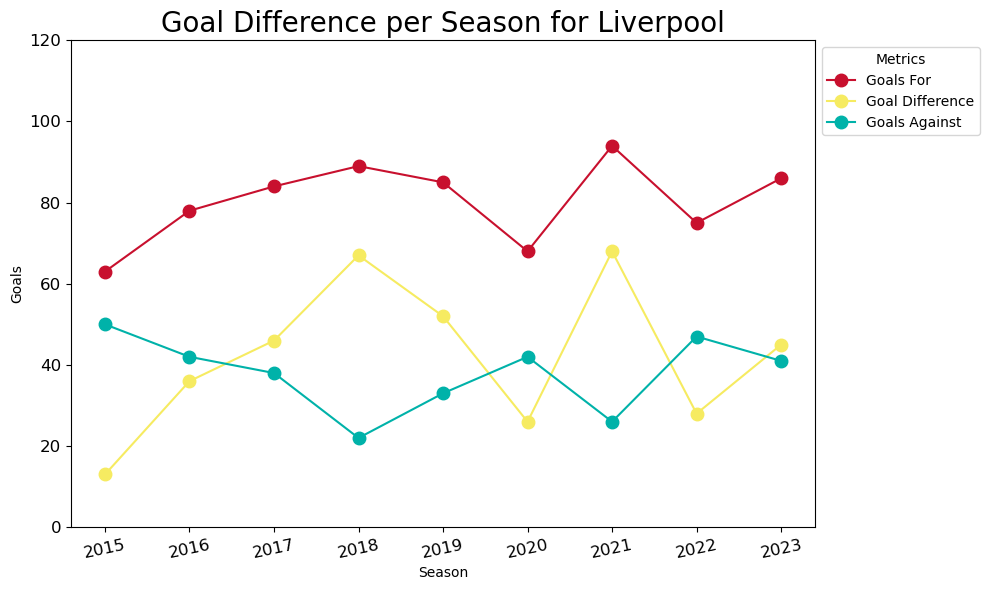

In [36]:
plot_team_goal_difference(pl, team_name="Liverpool", figsize=(10, 6), save_path="goal_difference_liverpool.png")


In [37]:
def plot_team_goal_difference_and_points(pl, team_name, figsize=(10, 6), save_path=None):
    """
    Plot the goal difference and points per season for a specific team.

    Parameters:
        pl (DataFrame): DataFrame containing the league position data.
        team_name (str): Name of the team to plot the goal difference and points for.
        figsize (tuple): Figure size (width, height) in inches.
        save_path (str): Path to save the plot (including filename and extension).

    Returns:
        None
    """
    # Filter the data for the specified team
    team_data = pl.loc[pl["name"] == team_name]

    # Group the data by season and calculate the mean metrics for each season
    team_metrics = team_data.groupby(["season"]).agg({'all_goals.for': 'mean', 'all_goals.against': 'mean', 'goalsDiff': 'mean', 'points': 'mean'}).reset_index()

    # Plotting
    fig, ax = plt.subplots(figsize=figsize)
    ax.set_ylim(0, 120)

    # Create the line chart for goals scored
    team_metrics.plot(x='season', y='all_goals.for', kind='line', marker='o', markersize=9, ax=ax, label='Goals For', color="#c8102E")

    # Plot goal difference
    team_metrics.plot(x='season', y='goalsDiff', kind='line', marker='o', markersize=9, ax=ax, label='Goal Difference', color="#F6EB61")

    # Create another line chart for goals against
    team_metrics.plot(x='season', y='all_goals.against', kind='line', marker='o', markersize=9, ax=ax, label='Goals Against', color="#00B2A9")

    # Create a line chart for points
    team_metrics.plot(x='season', y='points', kind='line', marker='o', markersize=9, ax=ax, label='Points', color="#73091a")

    # Customize the plot
    ax.set_title(f'Goal Difference and Points per Season for {team_name}', fontsize=20)
    ax.set_xlabel('Season')
    ax.set_ylabel('Metrics')
    plt.xticks(rotation=12, fontsize=12)  # Rotate x-axis labels for better readability
    plt.yticks(fontsize=12)

    # Move legend outside of the graph
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1), title='Metrics')

    plt.tight_layout()

    # Save the plot if save_path is provided
    if save_path:
        plt.savefig(save_path, dpi=300, transparent=False, bbox_inches='tight')

    plt.show()


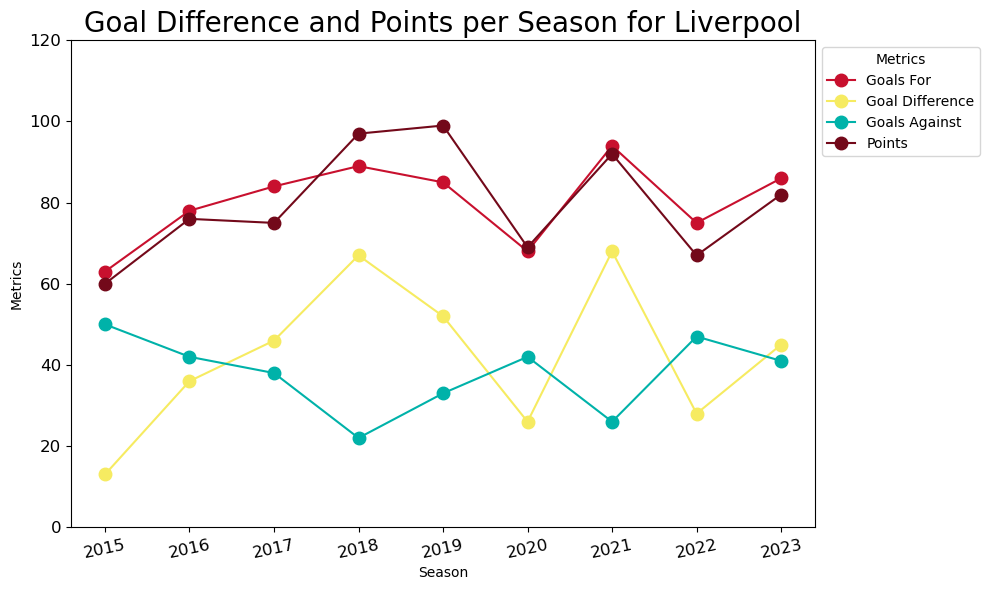

In [38]:
plot_team_goal_difference_and_points(pl,'Liverpool',save_path='liverpool_goals_points.png')

In [39]:
def plot_team_goals_home_away(pl, team_name, figsize=(10, 6), save_path=None):
    """
    Plot the total goals scored and conceded per season for a specific team.

    Parameters:
        pl (DataFrame): DataFrame containing the league position data.
        team_name (str): Name of the team to plot the goals for.
        figsize (tuple): Figure size (width, height) in inches.
        save_path (str): Path to save the plot (including filename and extension).

    Returns:
        None
    """
    # Filter the data for the specified team
    team_data = pl.loc[pl["name"] == team_name]

    # Group the data by season and calculate the total goals scored and conceded per season
    team_goals_home_away = team_data.groupby(["season"]).agg({'home_goals.for': 'sum', 'away_goals.for': 'sum', 'home_goals.against': 'sum', 'away_goals.against': 'sum'}).reset_index()

    # Create plot
    fig, ax = plt.subplots(figsize=figsize, facecolor='none')

    # Define custom colors for the bars
    colors = ['#c8102e', '#10c8aa', '#73091a', '#097362']

    # Create the bar chart with custom colors
    bars = team_goals_home_away.plot(kind='bar', x='season', ax=ax, color=colors)

    # Customize the plot
    ax.set_title(f'Goals Scored and Conceded per Season for {team_name}', fontsize=20)
    ax.set_xlabel('Season')
    ax.set_ylabel('Goals')
    plt.xticks(rotation=12, fontsize=12)
    plt.yticks(fontsize=12)

    # Move legend outside of the graph
    legend_labels = ['Home Goals Scored', 'Away Goals Scored', 'Home Goals Conceded', 'Away Goals Conceded']
    plt.legend(legend_labels, loc='upper left', bbox_to_anchor=(1, 1), title='Goals')

    plt.tight_layout()

    # Save the plot if save_path is provided
    if save_path:
        plt.savefig(save_path, dpi=300, transparent=False, bbox_inches='tight')

    plt.show()


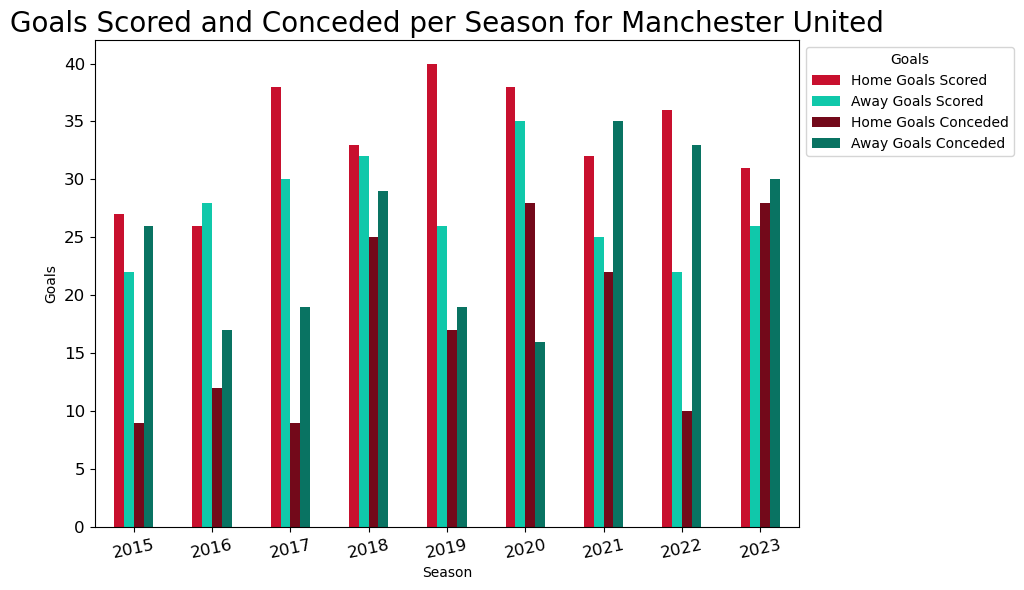

In [40]:
plot_team_goals_home_away(pl,'Manchester United', save_path='manu_goals_home_away.png')

In [41]:
def plot_team_win_rate(pl, team_name, figsize=(8, 6), save_path=None):
    """
    Plot the win rate for home and away games per season for a specific team.

    Parameters:
        pl (DataFrame): DataFrame containing the league position data.
        team_name (str): Name of the team to plot the win rate for.
        figsize (tuple): Figure size (width, height) in inches.
        save_path (str): Path to save the plot (including filename and extension).

    Returns:
        None
    """
    # Filter the data for the specified team
    team_data = pl.loc[pl["name"] == team_name]

    # Calculate the win rate for home and away games for each season
    home_win_rate_per_season = (team_data.groupby('season')['home_win'].mean() / team_data.groupby('season')['home_played'].mean()) * 100
    away_win_rate_per_season = (team_data.groupby('season')['away_win'].mean() / team_data.groupby('season')['away_played'].mean()) * 100

    # Plot the scatter plot
    fig, ax = plt.subplots(figsize=figsize, facecolor='none')

    # Set x and y axis limits to 0-100%
    ax.set_xlim(0, 100)
    ax.set_ylim(0, 100)

    # Iterate over each season and plot the data points with a unique color
    seasons = sorted(team_data['season'].unique())
    for i, season in enumerate(seasons):
        # Get the win rates for the current season
        home_win_rate = home_win_rate_per_season.loc[season]
        away_win_rate = away_win_rate_per_season.loc[season]
        
        # Define a unique color for each season
        color = plt.cm.tab10(i / len(seasons))  # Using a colormap to generate distinct colors
        
        # Scatter plot
        ax.scatter(home_win_rate, away_win_rate, label=season, color=color, s=125, edgecolor="black")

    # Customize the plot
    ax.set_title(f'{team_name} Home vs Away Win Rate per Season', fontsize=20)
    ax.set_xlabel('Home Win Rate (%)')
    ax.set_ylabel('Away Win Rate (%)')

    plt.xticks(range(10, 110, 10), fontsize=12)
    plt.yticks(range(10, 110, 10), fontsize=12)
    
    plt.grid(True, alpha=0.5)

    # Add legend
    ax.legend(title='Season')

    plt.tight_layout()

    # Save the plot if save_path is provided
    if save_path:
        plt.savefig(save_path, dpi=300, transparent=False, bbox_inches='tight')

    plt.show()


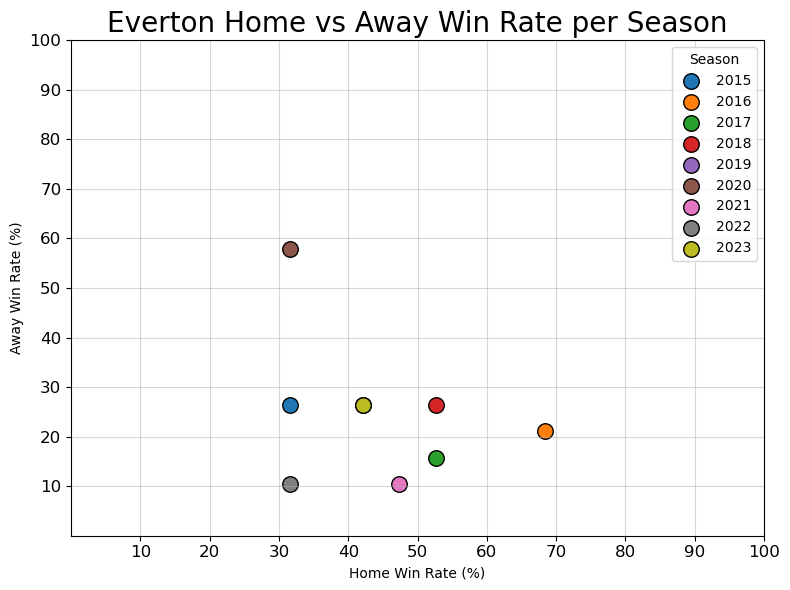

In [42]:
plot_team_win_rate(pl,"Everton", save_path='everton_winrate.png')

In [43]:
def plot_team_placement_vs_points(pl, team_name, figsize=(8, 6), save_path=None):
    """
    Plot the league placement vs points per season for a specific team.

    Parameters:
        pl (DataFrame): DataFrame containing the league position data.
        team_name (str): Name of the team to plot the data for.
        figsize (tuple): Figure size (width, height) in inches.
        save_path (str): Path to save the plot (including filename and extension).

    Returns:
        None
    """
    # Filter the data for the specified team
    team_data = pl.loc[pl["name"] == team_name]

    # Group the data by season and calculate the total points and rank for each season
    rank_per_season = team_data.groupby('season')['rank'].sum()
    points_per_season = team_data.groupby('season')['points'].sum()

    # Plot the scatter plot
    fig, ax = plt.subplots(figsize=figsize, facecolor='none')

    # Set x and y axis limits
    ax.set_xlim(20, 0)
    ax.set_ylim(0, 120)

    # Iterate over each season and plot the data points with a unique color
    seasons = sorted(team_data['season'].unique())
    for i, season in enumerate(seasons):
        # Get the points and rank for the current season
        points = points_per_season.loc[season]
        rank = rank_per_season.loc[season]
        
        # Define a unique color for each season
        color = plt.cm.tab10(i / len(seasons))  # Using a colormap to generate distinct colors
        
        # Scatter plot
        ax.scatter(rank, points, label=season, color=color, s=125, edgecolor="black")

    # Customize the plot
    ax.set_title(f'{team_name} League Placement vs Points per season', fontsize=20)
    ax.set_ylabel('Points')
    ax.set_xlabel('League Placement')

    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)

    plt.xticks(range(1, 21))
    plt.yticks(range(10, 120, 10))
    plt.grid(True, alpha=0.5)

    # Add legend
    ax.legend(title='Season')

    plt.tight_layout()

    # Save the plot if save_path is provided
    if save_path:
        plt.savefig(save_path, dpi=300, transparent=False, bbox_inches='tight')

    plt.show()


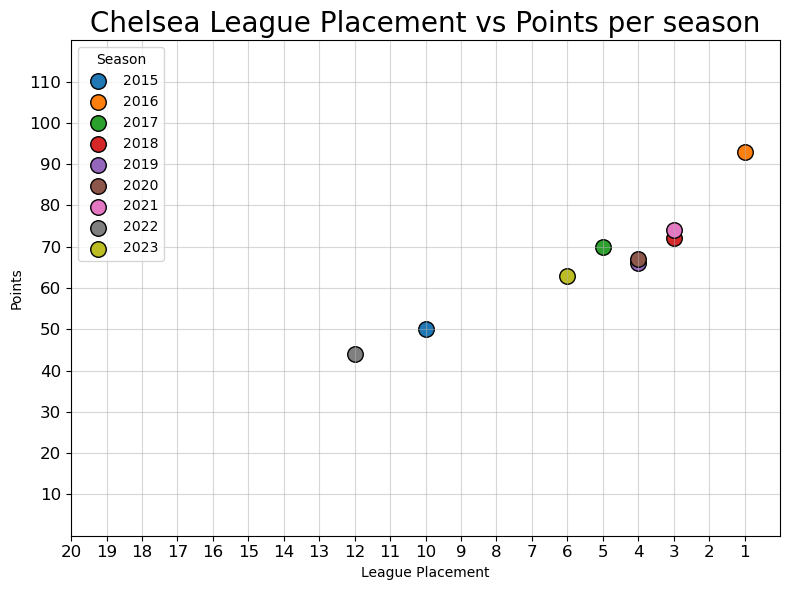

In [44]:
plot_team_placement_vs_points(pl,'Chelsea',save_path='chelsea_rank_points.png')

In [45]:
def plot_team_goals(pl, team_name, figsize=(10, 6), save_path=None):
    """
    Plot the goals scored and conceded per season for a specific team.

    Parameters:
        pl (DataFrame): DataFrame containing the league position data.
        team_name (str): Name of the team to plot the data for.
        figsize (tuple): Figure size (width, height) in inches.
        save_path (str): Path to save the plot (including filename and extension).

    Returns:
        None
    """
    # Filter the data for the specified team
    team_data = pl.loc[pl["name"] == team_name]

    # Group the data by season and calculate the total goals scored and conceded for each season
    goals_home_away = team_data.groupby(["season"]).agg({'home_goals.for': 'sum', 'home_goals.against': 'sum', 'away_goals.for': 'sum', 'away_goals.against': 'sum'}).reset_index()

    # Create plot
    fig, ax = plt.subplots(figsize=figsize)

    # Create the bar chart with custom colors
    colors = ['#c8102e', '#73091a', '#10c8aa', '#097362']
    bars = goals_home_away.plot(kind='bar', x='season', ax=ax, color=colors)

    # Customize the plot
    ax.set_title('Goals Scored and Conceded per Season', fontsize=20)
    ax.set_xlabel('Season')
    ax.set_ylabel('Goals')
    plt.xticks(rotation=12, fontsize=12)  # Rotate x-axis labels for better readability
    plt.yticks(fontsize=12)

    # Move legend outside of the graph
    legend_labels = ['Home Goals Scored', 'Home Goals Conceded', 'Away Goals Scored', 'Away Goals Conceded']
    plt.legend(legend_labels, loc='upper left', bbox_to_anchor=(1, 1), title='Goals')

    plt.tight_layout()

    # Save the plot if save_path is provided
    if save_path:
        plt.savefig(save_path, dpi=300, transparent=False, bbox_inches='tight')

    plt.show()


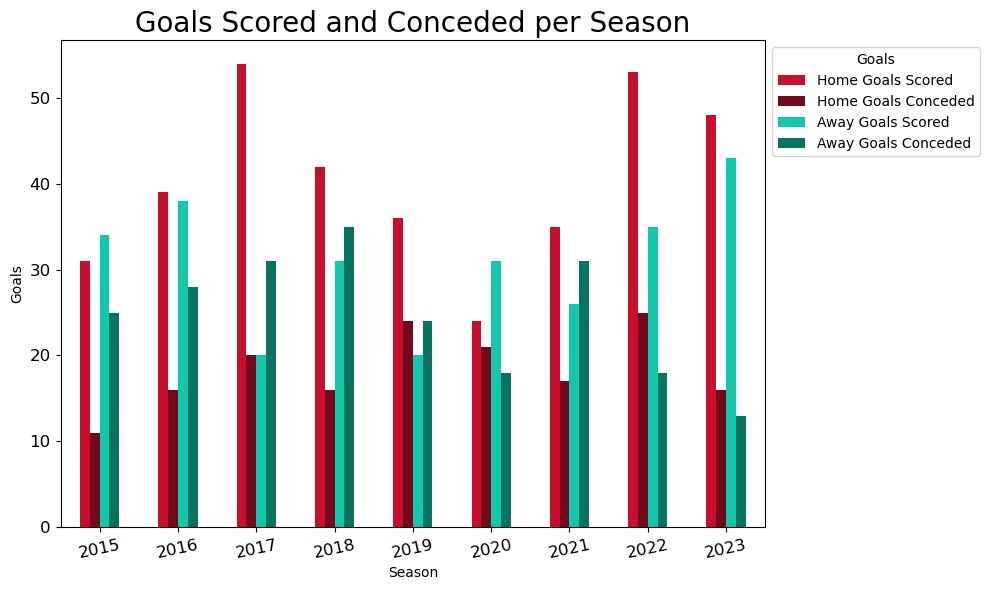

In [46]:
plot_team_goals(pl,'Arsenal',save_path='arsenal_goals.png')